In [3]:
from torchvision import transforms as T
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
import json
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ------------  CONFIG  -------------------
base_path = '/scratch/cv-course-group-5/data/dataset_jpg'
dst_root   = Path(base_path + '/preprocessed_dataset')
anno_file  = Path(base_path + '/dataset/annotations.json')

In [5]:
# Path to your JSON file
json_path = Path('mean_std.json')

# Load the file
with open(json_path, 'r') as f:
    mean_std_json = json.load(f)

mean = mean_std_json.get("mean", [])
std = mean_std_json.get("std", [])

In [6]:
# Path to your JSON file
json_path = Path('video_lists/train_test_split.json')

# Load the file
with open(json_path, 'r') as f:
    split_data = json.load(f)

# Access the train and test entries
train_list = split_data.get("train", [])

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

augmentations = transforms.Compose([
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.08)], 0.8),
    transforms.GaussianBlur(kernel_size=int(19), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
class CellDataset(Dataset):
    def __init__(self, video_list, path_to_videos, transform=T.ToTensor()):
        self.image_paths = []
        self.path_to_videos = path_to_videos
        self.transform = transform

        for video_dict in video_list:
            dst_path = path_to_videos / str(video_dict['name']) / 'images'
            self.image_paths += dst_path.glob('*.jpg')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2


In [9]:
transform = transforms.ToTensor()
dataset1 = CellDataset(video_list=train_list, path_to_videos=dst_root)
dataset = CellDataset(video_list=train_list, path_to_videos=dst_root, transform=augmentations)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.265406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.1725490531921387].


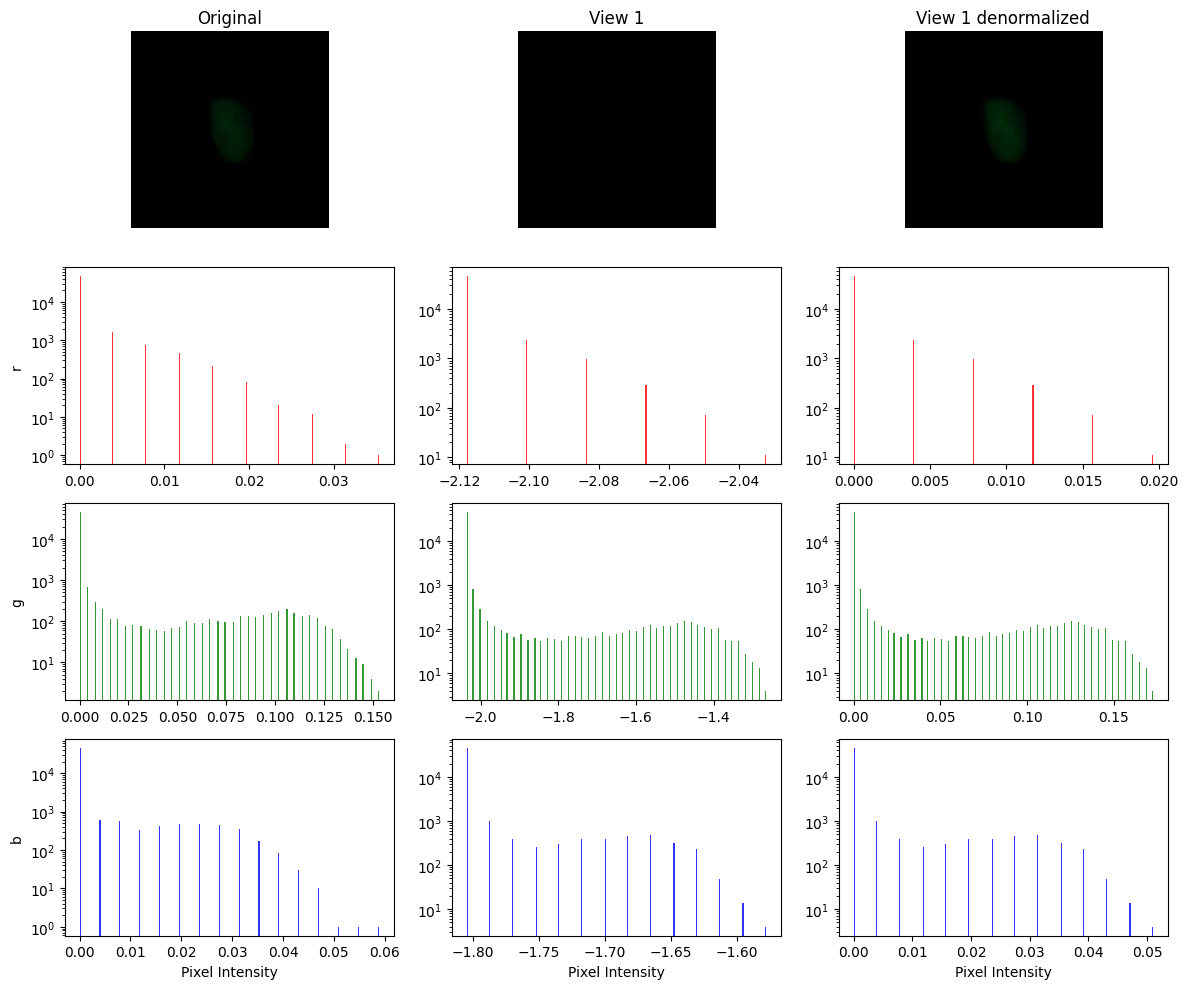

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.3354341].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.15686276626586915].


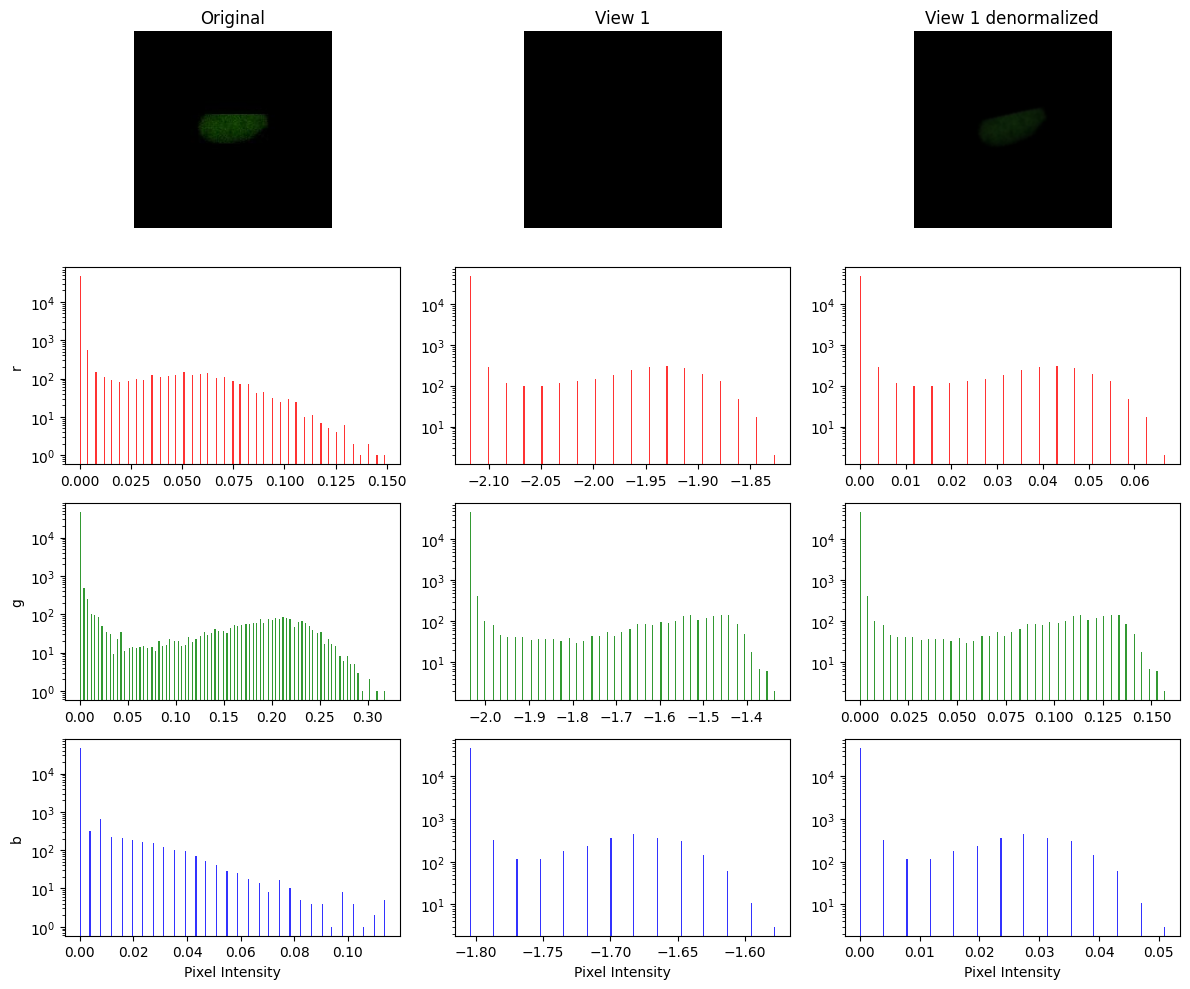

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8117647407054902].


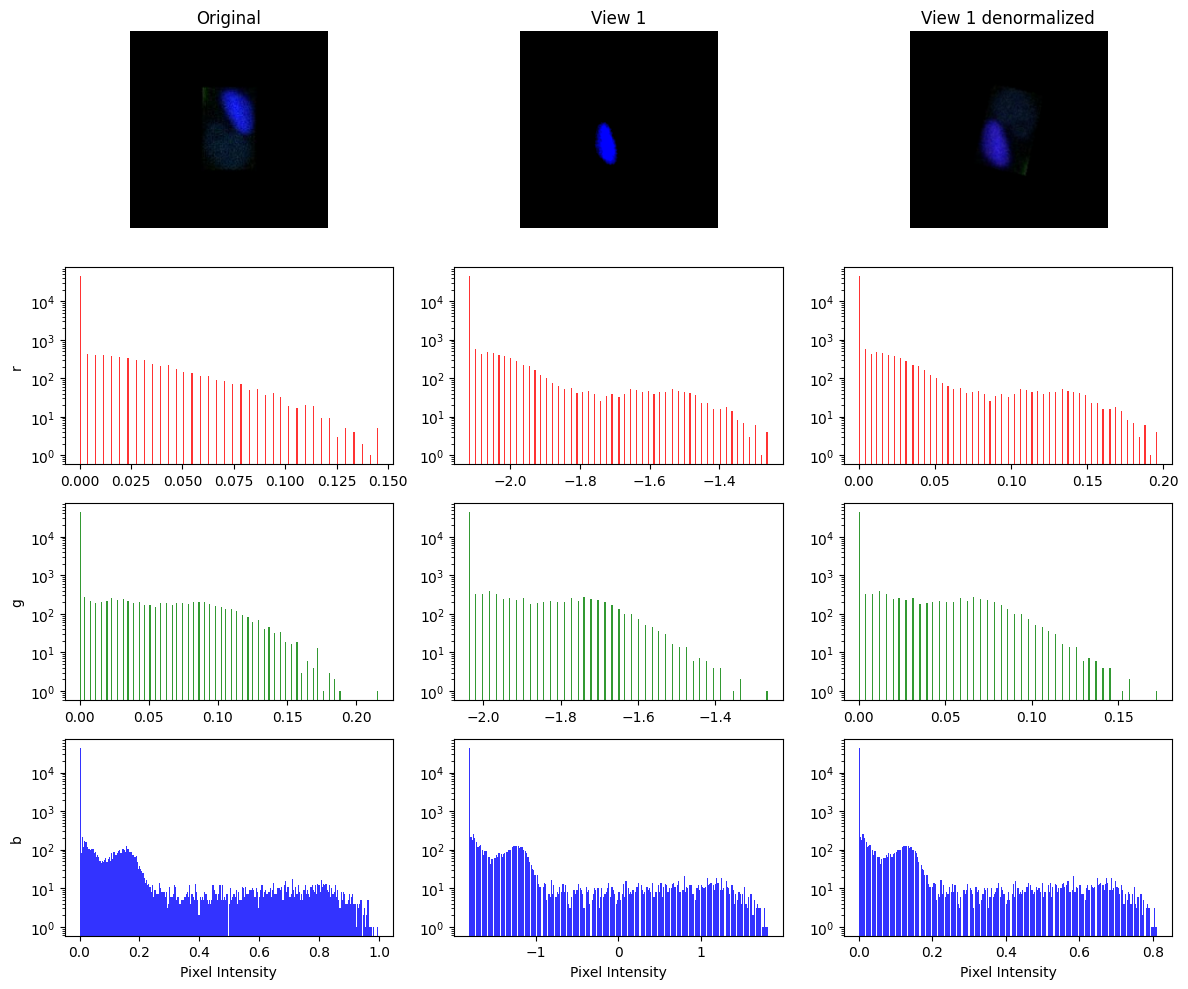

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.0561693].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.24313723683357236].


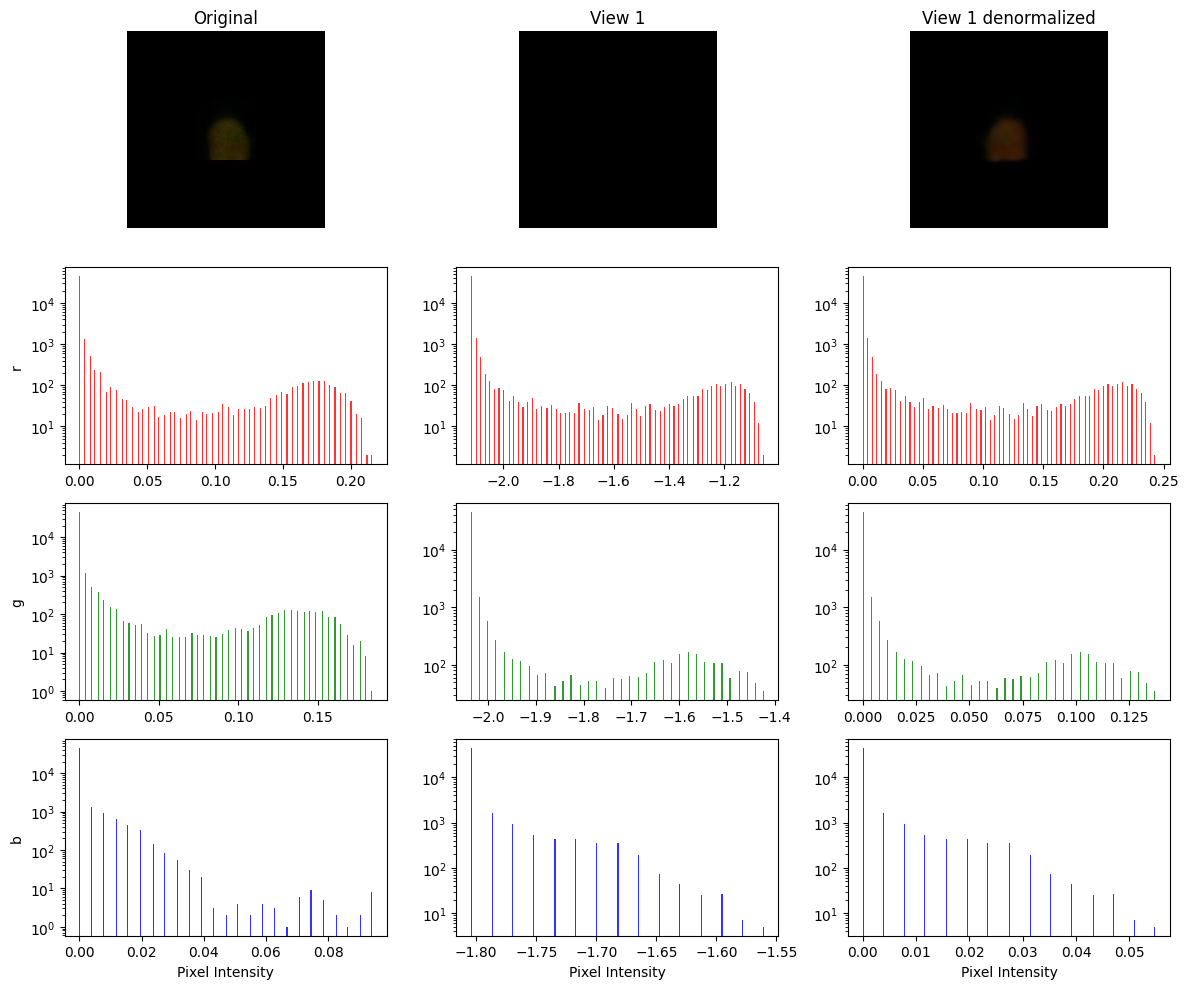

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-0.792717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.278431396484375].


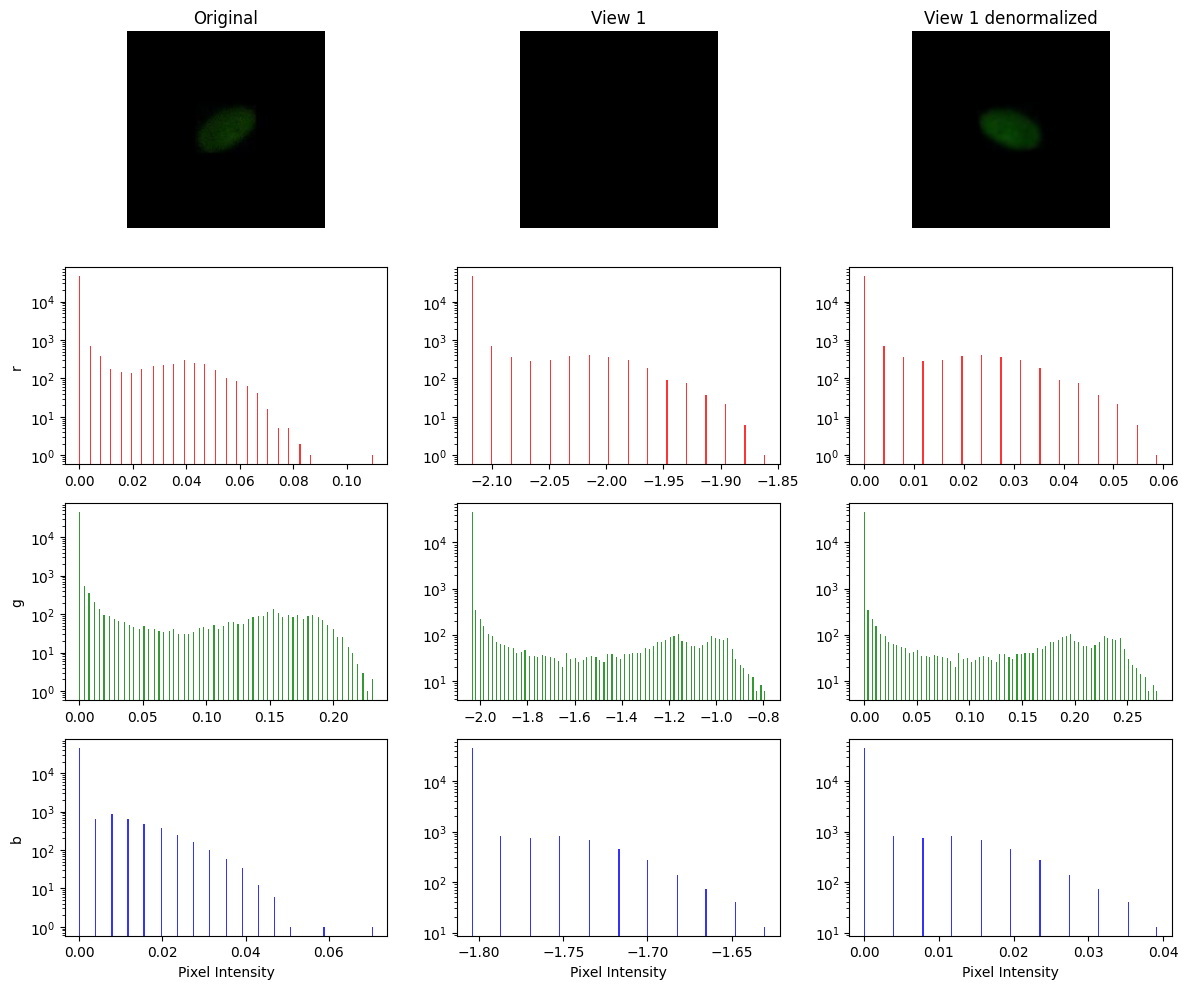

In [10]:
n = 5  # Number of samples

for i in range(50 * n, 51 * n):
    # Get images
    original = dataset1[i][0].permute(1, 2, 0).numpy()
    view1, view2 = dataset[i]
    img1 = view1.permute(1, 2, 0).numpy()
    img2 = view2.permute(1, 2, 0).numpy()

    img1_un = img1 * std + mean
    img2_un = img2 * std + mean

    images = [original, img1, img1_un]
    titles = ["Original", "View 1", "View 1 denormalized"]
    colors = ['r', 'g', 'b']

    plt.figure(figsize=(12, 10))

    # Top row: images
    for idx, img in enumerate(images):
        plt.subplot(4, 3, idx + 1)
        plt.imshow(img)
        plt.title(titles[idx])
        plt.axis('off')


    # Rows 2–4: R/G/B histograms for each image
    for img_idx, img in enumerate(images):  # img_idx = 0 (original), 1, 2
        for channel in range(3):  # 0 = R, 1 = G, 2 = B
            plot_idx = (channel + 1) * 3 + (img_idx + 1)  # 4x3 grid
            plt.subplot(4, 3, plot_idx)
            plt.hist(img[:, :, channel].flatten(), bins=256, color=colors[channel], alpha=0.8)

            if img_idx == 0:
                plt.ylabel(colors[channel])
            if channel == 2:
                plt.xlabel('Pixel Intensity')
            plt.yscale('log')

    plt.tight_layout()
    plt.show()